# Hyperparameter optimization

Grand et al data

Hyperparameter optimization on a development set.

# Reading the data

## GloVE

In [1]:
import os
from scipy import stats
import numpy as np 
import pandas as pd
import zipfile
import math
import sklearn
import torch
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt

In [2]:
glove_path = "glove/glove.42B.300d.zip"
glove_file = "glove.42B.300d.txt"

feature_dim = 300

word_vectors = { }

with zipfile.ZipFile(glove_path) as azip:
    with azip.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode()
            vector = np.array(values[1:], dtype=np.float32)
            word_vectors[word] = vector

## Grand features

In [3]:
grandratings_dir = "Grand_etal_csv/"
grandfeatures_path = "/Users/kee252/Data/grand_directions_in_space/features.xlsx"

grandfeatures_df = pd.read_excel(grandfeatures_path)

/Users/kee252/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Function for reading a specific Grand dataset

In [4]:
# reading in Grand data
def read_grand_data(filename, grandratings_dir, grandfeatures_df):
    # extract category and feature
    grandcategory, grandfeature = filename[:-4].split("_")
        
    # read human ratings, make gold column
    df = pd.read_csv(grandratings_dir + filename)
    df["Average"] = [row.iloc[1:26].sum() / 25 for _, row in df.iterrows()]
    # z-scores of average ratings
    df["Gold"] = (df["Average"] - df["Average"].mean()) / df["Average"].std()
        
    # obtain seed words from excel file
    relevant_row = grandfeatures_df[grandfeatures_df.Dimension == grandfeature]
    seedwords = relevant_row.iloc[:, 1:].values.flatten().tolist()
    pos_seedwords = seedwords[:3]
    neg_seedwords = seedwords[3:]
    
    return (grandcategory, grandfeature, pos_seedwords, neg_seedwords, df)

# Function for running crossvalidation

In [5]:
import eval_dim
import compute_dim
import statistics

def crossvalidation(filenames, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = 123, verbose = False):
    
    all_evals = [ ]
    
    for filename in filenames:
            grandcategory, grandfeature, pos_seedwords, neg_seedwords, df = read_grand_data(filename, 
                                                                                            grandratings_dir, 
                                                                                            grandfeatures_df)


            # storage for word vectors and gold values for this dataset
            all_thisdata_vectors = []
            all_thisdata_gold = []

            # collect word vectors and gold ratings
            for row in df.itertuples():
                # row.Row is the word. look it up in word_vectors
                all_thisdata_vectors.append( word_vectors[ row.Row ])
                # gold rating: use z-scored average
                all_thisdata_gold.append( row.Gold)

            # crossvalidation setup: give indices to datapoints
            fold = np.random.randint(method["numfolds"], size = len(all_thisdata_gold))

            # store the evaluation results from the different test folds
            evals = [ ]

            # iterate over folds, evaluate for each of them
            for testfold in range(method["numfolds"]):
                # compute training and test data for this fold
                test_indices =  [i for i in range(len(all_thisdata_gold)) if fold[i] == testfold]
                train_indices = [i for i in range(len(all_thisdata_gold)) if fold[i] != testfold]

                gold_test =  [ell["Gold"] for _, ell in df.iloc[ test_indices ].iterrows()]
                gold_train = [ ell["Gold"] for _, ell in df.iloc[ train_indices ].iterrows()]
                words_test =  [ell["Row"] for _, ell in df.iloc[ test_indices].iterrows()]
                words_train = [ell["Row"] for _, ell in df.iloc[ train_indices].iterrows()]
                vec_test =  [word_vectors[ w ] for w in words_test]
                vec_train = [word_vectors[ w ] for w in words_train ]


                # compute seed-based dimension, and its predictions
                if method["method"] == "seedbased":
                    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
                    df["Pred"] = compute_dim.predict_coord_fromtrain(vec_train, gold_train, dimension, all_thisdata_vectors)

                elif method["method"] == "fitted":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings(vec_train, gold_train, 
                                                                                       method["feature_dim"])
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seedwords":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seedwords(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"])
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seeddims":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seeddims(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"])
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "combined":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_combined(vec_train, gold_train,
                                                                    method["feature_dim"],
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"])
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "attseed":
                    dimension, weight, bias, _ = compute_dim.dimension_fitted_fromratings_attseeddims(vec_train, gold_train,
                                                                    method["feature_dim"],
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    alpha = method["alpha"])
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)
                    
                elif method["method"] == "attcombined":
                    dimension, weight, bias, _ = compute_dim.dimension_fitted_fromratings_attcombined(vec_train, gold_train,
                                                                    method["feature_dim"],
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    alpha = method["alpha"])
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                else:
                    raise Exception("shouldn't be here")

                # order consistency pairwise: test values tested for their ordering wrt. all values, training and test
                # MSE: evaluate on test only
                e = { "ocp" : eval_dim.pairwise_order_consistency_wrt(df["Gold"], df["Pred"], test_indices),
                      "mse" : eval_dim.mean_squared_error(gold_test, [p for i, p in enumerate(df["Pred"]) if i in test_indices]),
                      "feature" : grandfeature,
                      "category" : grandcategory}

                all_evals.append(e)

    if verbose:
        ocps = [e["ocp"] for e in all_evals if e["ocp"] is not None]
        mses = [e["mse"] for e in all_evals if e["mse"] is not None]

        print("\n\nOverall", method["method"], 
              f"OC_p {statistics.mean(ocps):.3f} ({statistics.stdev(ocps):.2f})", 
              f"MSE mean {statistics.mean(mses):.3f} ({statistics.stdev(mses):.2f}) median {statistics.median(mses):.3f}")
        
    return all_evals


# Function for aggregating crossvalidation results

First aggregate by dataset, then aggregate over datasets.

In [6]:
from collections import defaultdict
import statistics

def ocp_mse_crossvalidation_readoff(evals):
    bydataset_eval = defaultdict(list)
    
    for e in evals:
        bydataset_eval[ (e["category"], e["feature"])].append(e)
        
    ocp_mean = [ ]
    ocp_stdev = [ ]
    mse_mean = [ ]
    mse_stdev = [ ]
    mse_med = [ ]
    for ekey, es in bydataset_eval.items():
        os = [e["ocp"] for e in es]
        ms = [e["mse"] for m in es]
        ocp_mean.append( statistics.mean(os) )
        ocp_stdev.append( statistics.stdev(os))
        mse_mean.append( statistics.mean(ms) )
        mse_stdev.append( statistics.stdev(ms))
        mse_med.append( statistics.median(ms))
        
        
    return (statistics.mean(ocp_mean), statistics.mean(ocp_stdev), 
            statistics.mean(mse_mean), statistics.mean(mse_stdev), statistics.mean(mse_med))

# Making a development set

In [7]:
filenames = [f for f in os.listdir(grandratings_dir) if f.endswith("csv")]
[ filename[:-4].split("_") for filename in filenames]

import random
random.seed(789)
devset = random.sample(filenames, 6)
[ filename[:-4].split("_") for filename in devset]

[['cities', 'danger'],
 ['states', 'political'],
 ['animals', 'wetness'],
 ['cities', 'intelligence'],
 ['animals', 'weight'],
 ['names', 'age']]

# Determining hyperparameters

## Fitted dimensions with seeds as words: offset, jitter

First experiments looked like there was a lot of variance in result with different random seeds. To check into this, we run the hyperparameter tests 10 times with different random seeds. We then look at mean and standard deviation of the two measures we focus on: mean OC_p and median MSE.

In [22]:
jitter_vals = [True, False]
offset_vals= np.linspace(0.1, 2, num=20)

results = [ ]

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(10)]

for randval in randoms:
    for jval in jitter_vals:
        for oval in offset_vals:

            method = { "method": "fitted_seedwords",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "offset" : oval,
                      "jitter" : jval}


            evals = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            ocp_mean, ocp_stdev, mse_mean, mse_stdev, mse_med = ocp_mse_crossvalidation_readoff(evals)

            print(oval, jval, ocp_mean, mse_med)

            results.append( {"j": jval, "offset": oval, "ocp_mean" : ocp_mean, "ocp_stdev" : ocp_stdev, 
                             "mse_mean" : mse_mean, "mse_stdev" : mse_stdev, "mse_med" : mse_med})



0.1 True 0.6128073284110699 18.58336509452927
0.2 True 0.6038748206945486 14.447289285934028
0.3 True 0.6130482543407714 10.800004758607946
0.4 True 0.6197336240456216 11.249994105134812
0.5 True 0.6074111762856351 28.91458714541356
0.6 True 0.5955691518106484 15.362321767782383
0.7 True 0.6096026274867812 11.008377175960561
0.7999999999999999 True 0.5870433018732338 19.395835829527442
0.8999999999999999 True 0.5981063714567116 30.69473009662082
0.9999999999999999 True 0.6058432755201463 13.837347729578559
1.0999999999999999 True 0.5986180323718976 15.014880392096082
1.2 True 0.58907923382877 12.832273684710325
1.3 True 0.6152101312073484 25.471168382078087
1.4 True 0.6112565848110065 17.868974109649457
1.5 True 0.5920790705206289 7.620929606791115
1.5999999999999999 True 0.5908424241417439 31.976957159107723
1.7 True 0.6122236650978148 17.295746898270426
1.8 True 0.5975462349441941 13.628079389195268
1.9 True 0.6032897632592965 13.374495877392405
2.0 True 0.5921240907117076 10.8002191

In [23]:
# aggregating over multiple random seeds
results_all = defaultdict(list)
for r in results:
    results_all[(str(r["offset"]), r["j"])].append(r)
    


In [28]:
rnew = [ ]
for rs in results_all.values():
    rnew.append({"j": rs[0]["j"], "offset": rs[0]["offset"],
                 "ocp_mean":  statistics.mean([r["ocp_mean"] for r in rs]),
                 "ocp_stdev": statistics.mean([r["ocp_stdev"] for r in rs]),
                 "mse_mean":  statistics.mean([r["mse_mean"] for r in rs]),
                 "mse_med":   statistics.mean([r["mse_med"] for r in rs]),
                 "mse_stdev": statistics.mean([r["mse_stdev"] for r in rs]),
                 "ocp_mean_sd" : statistics.stdev([r["ocp_mean"] for r in rs]),
                 "mse_med_sd" : statistics.stdev([r["mse_med"] for r in rs])})

We plot mean OC_P values, with standard deviation. The differences in result are minimal compared to the error bars: It basically doesn't matter which value we pick. 

<AxesSubplot: >

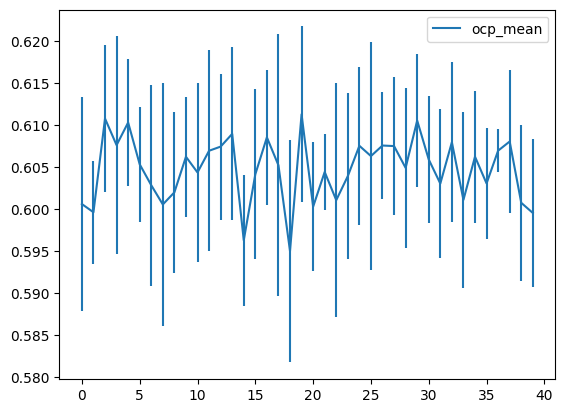

In [37]:
%matplotlib inline
df = pd.DataFrame(rnew)
df[df.j == False].plot(y = "ocp_mean", yerr = "ocp_mean_sd")

In [ ]:
df[df.j == True].plot(y = "ocp_mean", yerr = "ocp_mean_sd")

We plot mean values of median MSE, with standard deviation. Here the difference in results is clearly dwarfed by the error bars: It does not matter at all which values we pick. 

<AxesSubplot: >

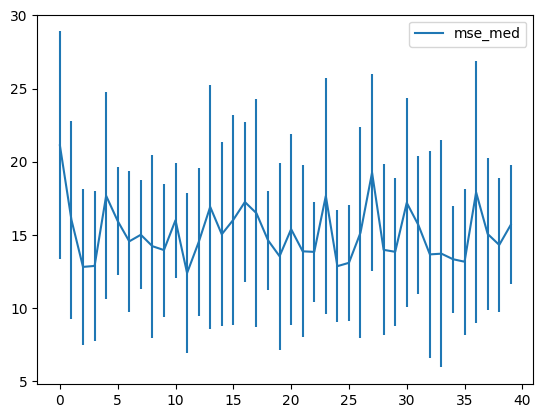

In [38]:
df[df.j == False].plot(y = "mse_med", yerr = "mse_med_sd")

In [ ]:
df[df.j == True].plot(y = "mse_med", yerr = "mse_med_sd")

### Parameters for seeds as words

Because we need to pick some value, we pick the one with best OC_P, since there it looked like there was at least a bit of signal in the differences in performance. We use an offset of 2.0, with jitter. 

In [40]:
df.sort_values(by = "ocp_mean", ascending = False).head(10)

,j,offset,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
19,True,2.0,0.611327,0.096036,13.544057,13.544057,0.0,0.010458,6.398902
2,True,0.3,0.610821,0.095631,12.815740,12.815740,0.0,0.008784,5.307797
29,False,1.0,0.610585,0.102370,13.845998,13.845998,0.0,0.007875,5.058050
4,True,0.5,0.610347,0.102480,17.673979,17.673979,0.0,0.007557,7.071903
13,True,1.4,0.608995,0.098169,16.917252,16.917252,0.0,0.010304,8.353812
16,True,1.7,0.608581,0.105567,17.248765,17.248765,0.0,0.008018,5.463205
37,False,1.8,0.608087,0.102141,15.064722,15.064722,0.0,0.008475,5.220893
32,False,1.3,0.608000,0.098593,13.669928,13.669928,0.0,0.009516,7.076561
3,True,0.4,0.607656,0.101828,12.880991,12.880991,0.0,0.012969,5.126581
26,False,0.7,0.607609,0.097787,15.152610,15.152610,0.0,0.006364,7.219939


## Fitted dimensions with seeds as dimensions: alpha, averaging

We again run this several times, to see how much the results depend on random seeds. 

In [28]:
alpha_vals= np.linspace(0.005, 0.1, num=5)
jitter_vals = [True, False]
offset_vals= np.linspace(0.1, 2, num=3)
results = [ ]

# random.seed(5)
# randoms = [random.randrange(0,100) for _ in range(10)]
randoms = [123]

for randval in randoms:
    for alphaval in alpha_vals:
        for jval in jitter_vals:
                for oval in offset_vals:
                    method = { "method": "attcombined",
                              "feature_dim" : feature_dim,
                              "numfolds" : 5,
                              "alpha" : alphaval,
                              "offset" : oval,
                              "jitter" : jval,
                             }


                    evals = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
                    ocp_mean, ocp_stdev, mse_mean, mse_stdev, mse_med = ocp_mse_crossvalidation_readoff(evals)

                    print(alphaval, oval, jval, ocp_mean, mse_med)

                    results.append( {"alpha": alphaval, "j": jval, "offset": oval, 
                                     "ocp_mean" : ocp_mean, "ocp_stdev" : ocp_stdev, 
                                     "mse_mean" : mse_mean, "mse_stdev" : mse_stdev, "mse_med" : mse_med})



0.005 0.1 True 0.5856580251518226 16.672478503886325
0.005 1.05 True 0.586671262153637 15.385596656503079
0.005 2.0 True 0.5967504761316832 17.52287105957711
0.005 0.1 False 0.6098924887785432 23.18717104466776
0.005 1.05 False 0.5843061568061568 51.987886265311
0.005 2.0 False 0.5949044752581167 16.011502366473856
0.02875 0.1 True 0.6075401354297458 18.361060229169123
0.02875 1.05 True 0.5949225302286527 9.746587099192654
0.02875 2.0 True 0.5942073948912474 21.132031824060515
0.02875 0.1 False 0.6143694942280286 16.549364411999143
0.02875 1.05 False 0.5799949738470147 6.802420496389969
0.02875 2.0 False 0.5985500104541357 24.939165282717113
0.0525 0.1 True 0.6110744716356962 13.81235807907875
0.0525 1.05 True 0.6146151864009006 15.207989446789874
0.0525 2.0 True 0.6059260045824671 11.176803251175814
0.0525 0.1 False 0.6133383846564119 9.442780088172338
0.0525 1.05 False 0.6033444522220033 21.310733855105877
0.0525 2.0 False 0.5958548679211945 14.543178438438702
0.07625000000000001 0.1

<AxesSubplot: xlabel='alpha'>

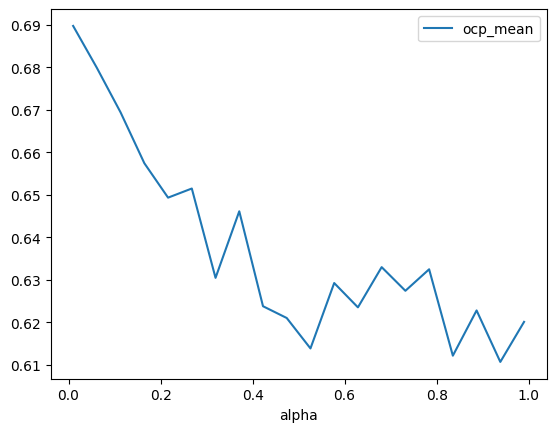

In [46]:
df = pd.DataFrame(results)
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean")

<AxesSubplot: xlabel='alpha'>

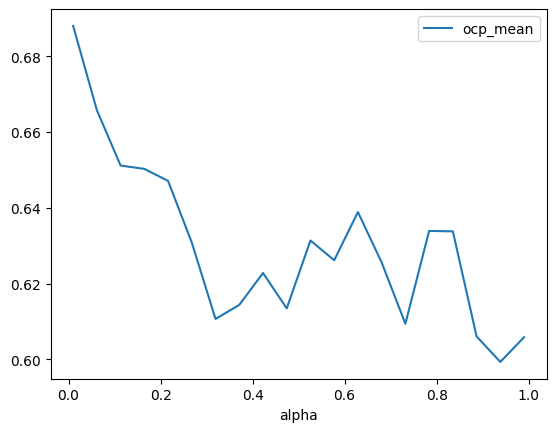

In [47]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean")

<AxesSubplot: xlabel='alpha'>

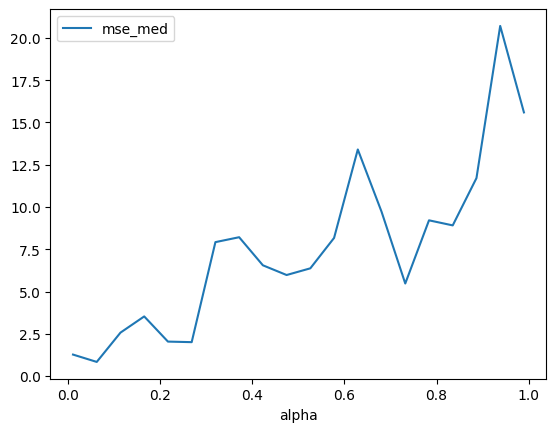

In [48]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "mse_med")

<AxesSubplot: xlabel='alpha'>

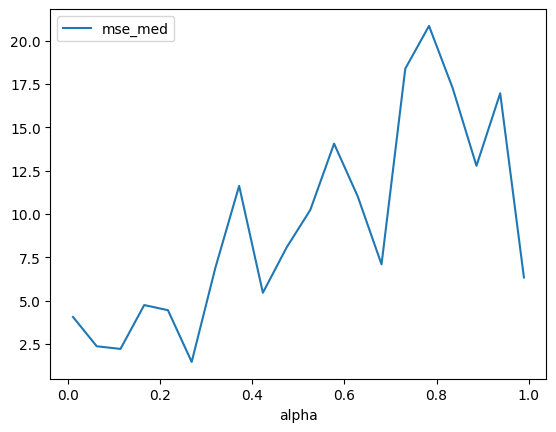

In [49]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "mse_med")

We see that overall the performance is best, in terms of both OC_P and MSE, for small values of alpha. We explore the low range of alpha in more detail, both with and without averaging. OC_P values take a steep dive from about 0.68 to about 0.62 when alpha rises from 0.01 to 0.25. At about 0.25, MSE starts to rise steeply.  

This time we do re-run the analysis several times to obtain error bars.

In [50]:
average_vals = [True, False]
alpha_vals= np.linspace(0.005, 0.25, num=10)

results = [ ]

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(5)]
# randoms = [123]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            evals = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            ocp_mean, ocp_stdev, mse_mean, mse_stdev, mse_med = ocp_mse_crossvalidation_readoff(evals)

            print(avgval, alphaval, ocp_mean, mse_med)

            results.append( {"avg": avgval, "alpha": alphaval, "ocp_mean" : ocp_mean, "ocp_stdev" : ocp_stdev, 
                             "mse_mean" : mse_mean, "mse_stdev" : mse_stdev, "mse_med" : mse_med})



True 0.005 0.6975483077013689 6.562411028266701
True 0.03222222222222222 0.6804743647005552 2.7821478643705255
True 0.05944444444444444 0.6905348071040711 0.371666697694623
True 0.08666666666666667 0.6666602369663595 1.9296027472366815
True 0.11388888888888889 0.6721254677547195 5.319040093293211
True 0.1411111111111111 0.6694184812644923 2.2503607809035318
True 0.16833333333333333 0.6505041972388911 3.0652131180588458
True 0.19555555555555554 0.655366306830438 5.943349200546577
True 0.22277777777777777 0.6533196584216993 4.958095768460784
True 0.25 0.6438415332462952 7.432474965114673
False 0.005 0.7050498225405462 4.772738098798078
False 0.03222222222222222 0.6686980844787149 2.129678611742316
False 0.05944444444444444 0.6694499122114259 0.8279685136266204
False 0.08666666666666667 0.6711148954346233 5.0410390351507965
False 0.11388888888888889 0.644603713243169 3.982240014393412
False 0.1411111111111111 0.6483900396655499 3.5681246433978964
False 0.16833333333333333 0.64570724249295

In [52]:
# aggregating over multiple random seeds
results_all = defaultdict(list)
for r in results:
    results_all[(str(r["alpha"]), r["avg"])].append(r)
    


In [53]:
rnew = [ ]
for rs in results_all.values():
    rnew.append({"avg": rs[0]["avg"], "alpha": rs[0]["alpha"],
                 "ocp_mean":  statistics.mean([r["ocp_mean"] for r in rs]),
                 "ocp_stdev": statistics.mean([r["ocp_stdev"] for r in rs]),
                 "mse_mean":  statistics.mean([r["mse_mean"] for r in rs]),
                 "mse_med":   statistics.mean([r["mse_med"] for r in rs]),
                 "mse_stdev": statistics.mean([r["mse_stdev"] for r in rs]),
                 "ocp_mean_sd" : statistics.stdev([r["ocp_mean"] for r in rs]),
                 "mse_med_sd" : statistics.stdev([r["mse_med"] for r in rs])})

We again plot average OC_P mean and MSE median values, with error bars. 

<AxesSubplot: xlabel='alpha'>

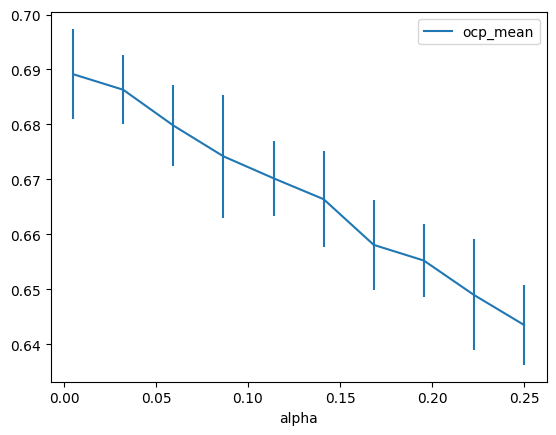

In [57]:
%matplotlib inline
df = pd.DataFrame(rnew)
df[df.avg == True].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_mean_sd")

<AxesSubplot: xlabel='alpha'>

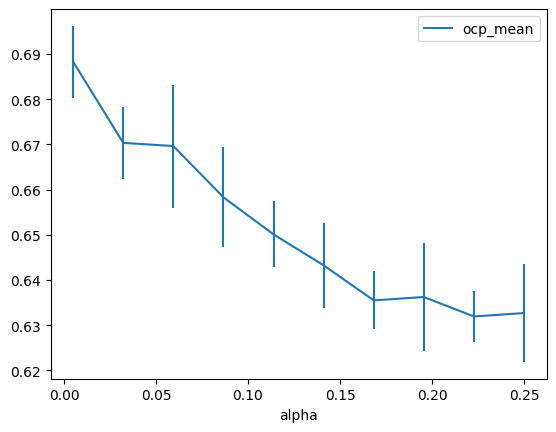

In [58]:
df[df.avg == False].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_mean_sd")

<AxesSubplot: xlabel='alpha'>

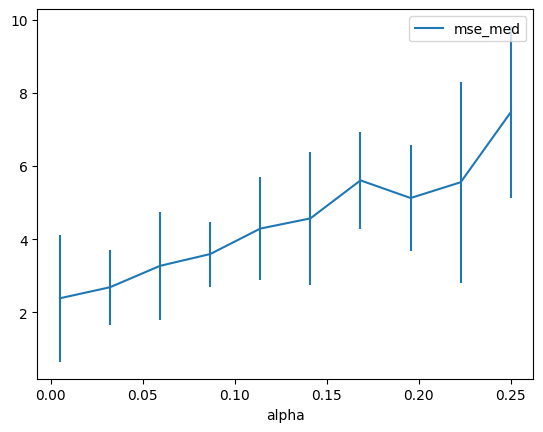

In [59]:
df[df.avg == False].plot(y = "mse_med", x = "alpha", yerr = "mse_med_sd")

<AxesSubplot: xlabel='alpha'>

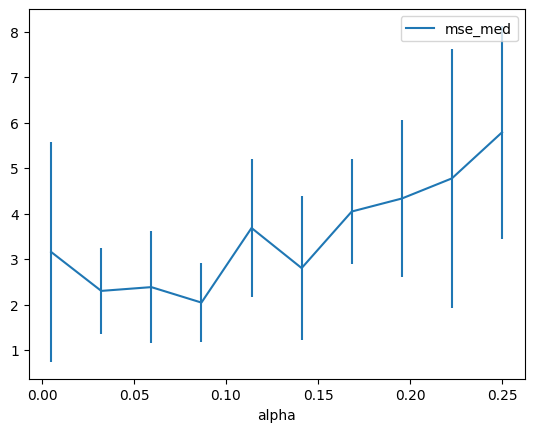

In [60]:
df[df.avg == True].plot(y = "mse_med", x = "alpha", yerr = "mse_med_sd")

Here the picture is quite clear: The lowest value for alpha works best, both in terms of OC_P and MSE. Visually, there doesn't seem to be much difference between averaging and not averaging over seed dimensions. We look at the numbers:

In [65]:
df[df.avg == True].sort_values(by = 'ocp_mean', ascending = False).head(3)

,avg,alpha,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
0,True,0.005000,0.689143,0.066140,3.156307,3.156307,0.0,0.008239,2.416624
1,True,0.032222,0.686306,0.075431,2.300633,2.300633,0.0,0.006312,0.945475
2,True,0.059444,0.679803,0.078032,2.383752,2.383752,0.0,0.007382,1.222881


In [66]:
df[df.avg == False].sort_values(by = 'ocp_mean', ascending = False).head(3)

,avg,alpha,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
10,False,0.005000,0.688298,0.067702,2.388034,2.388034,0.0,0.007925,1.738741
11,False,0.032222,0.670345,0.085499,2.688822,2.688822,0.0,0.007936,1.029400
12,False,0.059444,0.669648,0.087684,3.273789,3.273789,0.0,0.013600,1.471298


In [67]:
df[df.avg == False].sort_values(by = 'mse_med').head(3)

,avg,alpha,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
10,False,0.005000,0.688298,0.067702,2.388034,2.388034,0.0,0.007925,1.738741
11,False,0.032222,0.670345,0.085499,2.688822,2.688822,0.0,0.007936,1.029400
12,False,0.059444,0.669648,0.087684,3.273789,3.273789,0.0,0.013600,1.471298


In [68]:
df[df.avg == True].sort_values(by = 'mse_med').head(3)

,avg,alpha,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
3,True,0.086667,0.674190,0.085142,2.043937,2.043937,0.0,0.011216,0.860360
1,True,0.032222,0.686306,0.075431,2.300633,2.300633,0.0,0.006312,0.945475
2,True,0.059444,0.679803,0.078032,2.383752,2.383752,0.0,0.007382,1.222881


Overall we find the best results for **alpha = 0.005**. OC_P results are basically the same with and without averaging. MSE median values are lower with averaging and for alpha = 0.08, but that alpha value gets much worse OC_P values. So we instead go with the variant **without averaging**. 

# Combined model: seeds as words and dimensions

Do we still get the same best parameters when we combine the two models?

In [72]:
average_vals = [True, False]
alpha_vals= np.linspace(0.005, 0.2, num=5)
jitter_vals = [True, False]
offset_vals= np.linspace(0.1, 2, num=5)


results = [ ]

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(3)]
randoms = [123]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:
            for oval in offset_vals:
                for jval in jitter_vals:

                    method = { "method": "combined",
                              "feature_dim" : feature_dim,
                              "numfolds" : 5,
                              "do_average" : avgval,
                              "alpha" : alphaval,
                              "offset" : oval,
                              "jitter" : jval}


                    evals = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
                    ocp_mean, ocp_stdev, mse_mean, mse_stdev, mse_med = ocp_mse_crossvalidation_readoff(evals)

                    print(avgval, jval, alphaval, oval, ocp_mean, mse_med)

                    results.append( {"avg": avgval, "alpha": alphaval, "j" : jval, "offset" : oval,
                                     "ocp_mean" : ocp_mean, "ocp_stdev" : ocp_stdev, 
                                     "mse_mean" : mse_mean, "mse_stdev" : mse_stdev, "mse_med" : mse_med})



True True 0.005 0.1 0.6984012189624434 3.0171446691324775
True False 0.005 0.1 0.7069541185125601 1.4009522469294806
True True 0.005 0.575 0.6963334907722663 0.6211946543135022
True False 0.005 0.575 0.7085762641467651 0.855896639457931
True True 0.005 1.05 0.7115533097768719 1.364411164303504
True False 0.005 1.05 0.7163621531872923 2.6673145584808395
True True 0.005 1.525 0.7016006428807913 0.7807102904320783
True False 0.005 1.525 0.7021558724264352 0.34281790661115524
True True 0.005 2.0 0.7031854256854257 0.8903331048150492
True False 0.005 2.0 0.7139391431268182 1.519919959741873
True True 0.06625 0.1 0.8312095288069314 0.48557330273609783
True False 0.06625 0.1 0.8297395889572761 0.2814509587423559
True True 0.06625 0.575 0.8252357559067516 0.164528648910271
True False 0.06625 0.575 0.834063773916715 0.15530444732608256
True True 0.06625 1.05 0.8225215091031418 0.5134290254980938
True False 0.06625 1.05 0.831377919876683 0.06293452960306864
True True 0.06625 1.525 0.826414104288

## Plotting the results

We get 5 bars per alpha value, one for each offset value. Overall impression: there is a sweet spot for alpha around 0.0625 both in terms of OC_P and MSE, which holds across all values of jitter and averaging. There doesn't seem to be any consistent effect of offsets. We explore that area of alpha in more detail, with several random settings. 

<AxesSubplot: xlabel='alpha'>

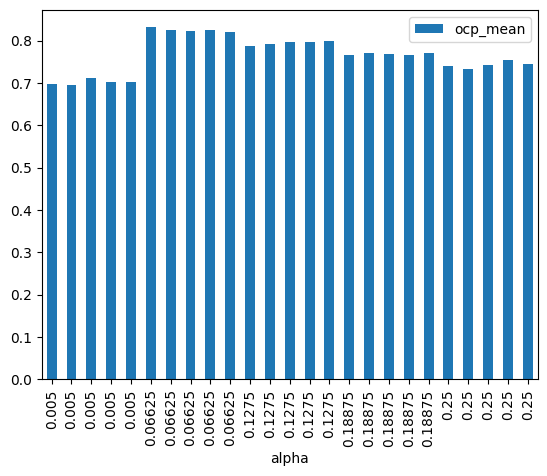

In [81]:
df = pd.DataFrame(results)
df[(df.j == True) & (df.avg == True)].plot(x="alpha", y = "ocp_mean", kind = "bar")

<AxesSubplot: xlabel='alpha'>

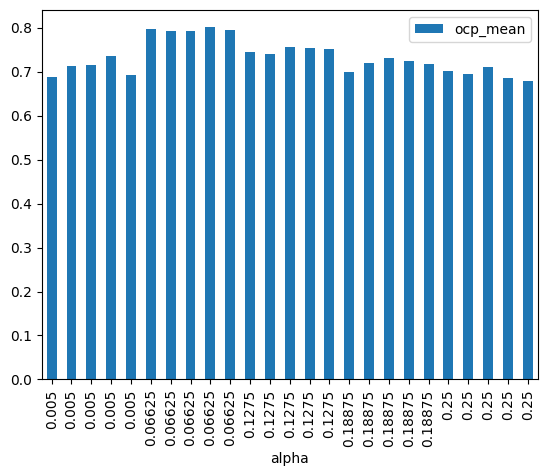

In [82]:
df[(df.j == True) & (df.avg == False)].plot(x="alpha", y = "ocp_mean", kind = "bar")

<AxesSubplot: xlabel='alpha'>

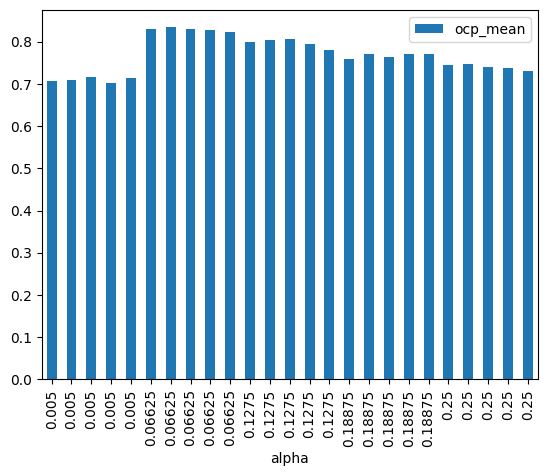

In [83]:
df[(df.j == False) & (df.avg == True)].plot(x="alpha", y = "ocp_mean", kind = "bar")

<AxesSubplot: xlabel='alpha'>

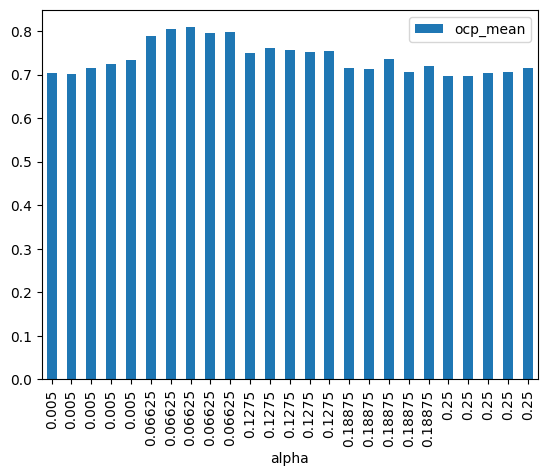

In [84]:
df[(df.j == False) & (df.avg == False)].plot(x="alpha", y = "ocp_mean", kind = "bar")

<AxesSubplot: xlabel='alpha'>

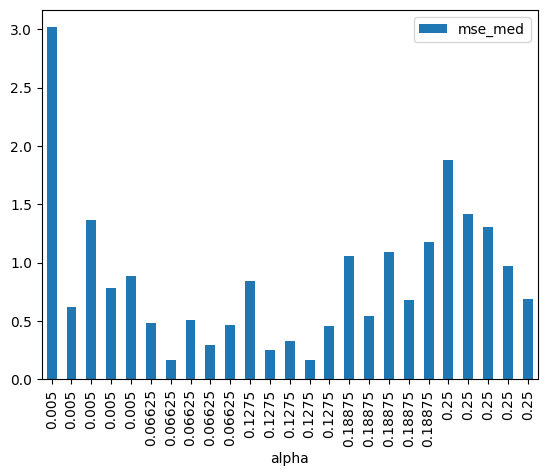

In [85]:
df[(df.j == True) & (df.avg == True)].plot(x="alpha", y = "mse_med", kind = "bar")

<AxesSubplot: xlabel='alpha'>

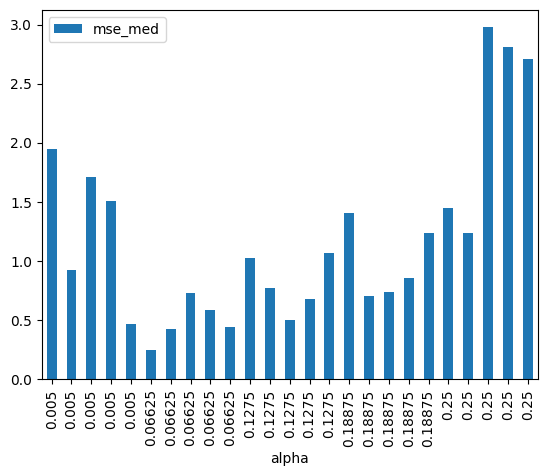

In [86]:
df[(df.j == True) & (df.avg == False)].plot(x="alpha", y = "mse_med", kind = "bar")

<AxesSubplot: xlabel='alpha'>

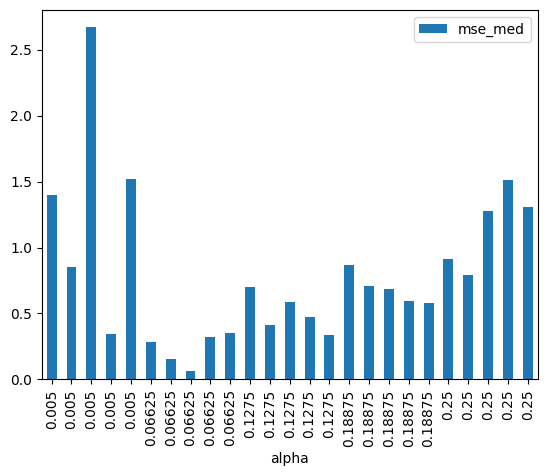

In [87]:
df[(df.j == False) & (df.avg == True)].plot(x="alpha", y = "mse_med", kind = "bar")

<AxesSubplot: xlabel='alpha'>

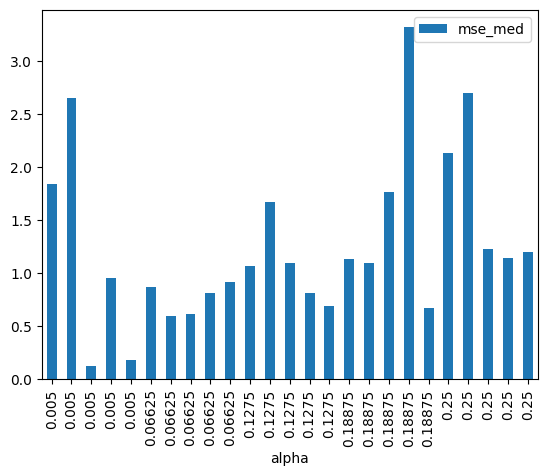

In [88]:
df[(df.j == False) & (df.avg == False)].plot(x="alpha", y = "mse_med", kind = "bar")

In [89]:
average_vals = [True, False]
alpha_vals= np.linspace(0.005, 0.12, num=10)
jitter_vals = [True, False]
offset_vals= np.linspace(0.1, 2, num=3)


results = [ ]

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(3)]


for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:
            for oval in offset_vals:
                for jval in jitter_vals:

                    method = { "method": "combined",
                              "feature_dim" : feature_dim,
                              "numfolds" : 5,
                              "do_average" : avgval,
                              "alpha" : alphaval,
                              "offset" : oval,
                              "jitter" : jval}


                    evals = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
                    ocp_mean, ocp_stdev, mse_mean, mse_stdev, mse_med = ocp_mse_crossvalidation_readoff(evals)

                    print(avgval, jval, alphaval, oval, ocp_mean, mse_med)

                    results.append( {"avg": avgval, "alpha": alphaval, "j" : jval, "offset" : oval,
                                     "ocp_mean" : ocp_mean, "ocp_stdev" : ocp_stdev, 
                                     "mse_mean" : mse_mean, "mse_stdev" : mse_stdev, "mse_med" : mse_med})



True True 0.005 0.1 0.6950107890460395 2.754165496688548
True False 0.005 0.1 0.6926675020506189 2.9209096008160422
True True 0.005 1.05 0.7052991855712945 2.5214528299532954
True False 0.005 1.05 0.7004427088749909 0.9321550381062963
True True 0.005 2.0 0.7163084474734135 3.610084984990144
True False 0.005 2.0 0.6921625859195433 0.6123376174166413
True True 0.017777777777777778 0.1 0.7260719602896474 1.7956395302417063
True False 0.017777777777777778 0.1 0.7363638805135404 1.5500340948027063
True True 0.017777777777777778 1.05 0.7624194037026443 1.1931978903708618
True False 0.017777777777777778 1.05 0.7617637879882778 0.49053623190571644
True True 0.017777777777777778 2.0 0.782051842715108 1.4449467201733217
True False 0.017777777777777778 2.0 0.7761742237132393 0.3100985609978457
True True 0.030555555555555555 0.1 0.8291700995527527 0.790606287072366
True False 0.030555555555555555 0.1 0.8221005875802795 1.180541077790353
True True 0.030555555555555555 1.05 0.8278150922121237 0.7190

In [92]:
# aggregating over multiple random seeds
results_all = defaultdict(list)
for r in results:
    results_all[(str(r["alpha"]), str(r["offset"]), r["avg"], r["j"])].append(r)
    


In [93]:
rnew = [ ]
for rs in results_all.values():
    rnew.append({"avg": rs[0]["avg"], "alpha": rs[0]["alpha"],
                 "j" : rs[0]["j"], "offset" : rs[0]["offset"],
                 "ocp_mean":  statistics.mean([r["ocp_mean"] for r in rs]),
                 "ocp_stdev": statistics.mean([r["ocp_stdev"] for r in rs]),
                 "mse_mean":  statistics.mean([r["mse_mean"] for r in rs]),
                 "mse_med":   statistics.mean([r["mse_med"] for r in rs]),
                 "mse_stdev": statistics.mean([r["mse_stdev"] for r in rs]),
                 "ocp_mean_sd" : statistics.stdev([r["ocp_mean"] for r in rs]),
                 "mse_med_sd" : statistics.stdev([r["mse_med"] for r in rs])})

In [94]:
df = pd.DataFrame(rnew)

A first rough look: what is the effect of jitter and averaging? Overall we get better values with averaging, but jitter or not doesn't make much of a difference. 

In [100]:
for j in [True, False]:
    for av in [True, False]:
        print("jitter", j, "avg", av, "ocp_mean", df[(df.j == j) & (df.avg == av)].ocp_mean.mean(), 
              "mse_med", df[(df.j == j) & (df.avg == av)].mse_med.mean())
 
print()

for j in [True, False]:
    for av in [True, False]:
        print("jitter", j, "avg", av, "ocp_mean max", df[(df.j == j) & (df.avg == av)].ocp_mean.max(), 
              "mse_med min", df[(df.j == j) & (df.avg == av)].mse_med.min())
 

jitter True avg True ocp_mean 0.7992281060521604 mse_med 0.6739395916549961
jitter True avg False ocp_mean 0.7831289540495922 mse_med 0.7054487547492505
jitter False avg True ocp_mean 0.7985589085758362 mse_med 0.5718074917485697
jitter False avg False ocp_mean 0.7834658159809104 mse_med 0.6992717293210018

jitter True avg True ocp_mean max 0.8391474081973782 mse_med min 0.2668560425507531
jitter True avg False ocp_mean max 0.8318660621879 mse_med min 0.32623817577968894
jitter False avg True ocp_mean max 0.841008191185652 mse_med min 0.26418331432721553
jitter False avg False ocp_mean max 0.8327289463649433 mse_med min 0.3385327977769514


**Averaging, no jitter**, one plot per offset value: We see that we get the best values for **offset 0.1**. Also, for all three offset values, the best performance is at an **alpha of 0.04. **

offset
0.10    AxesSubplot(0.125,0.11;0.775x0.77)
1.05    AxesSubplot(0.125,0.11;0.775x0.77)
2.00    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

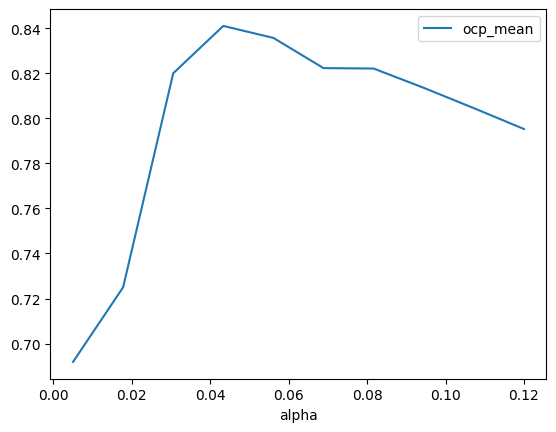

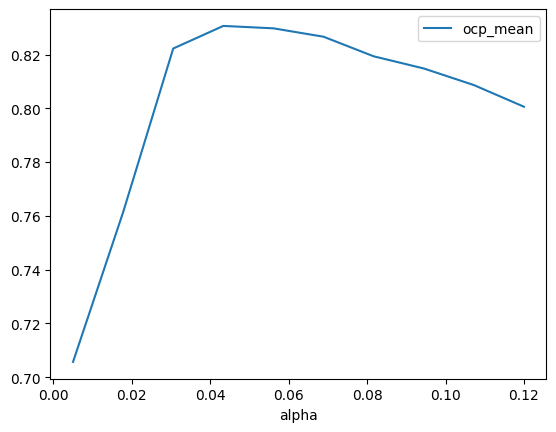

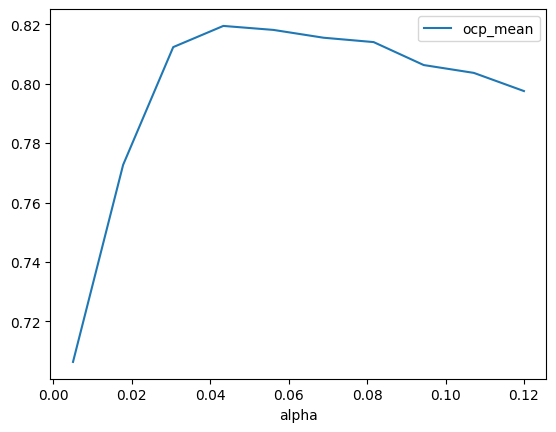

In [106]:
df[(df.j == False) & (df.avg == True)].groupby("offset").plot(x = "alpha", y = "ocp_mean")

We see similar curves for other combinations of jitter and averaging values, always with the best performance at alpha = 0.04 and offset = 0.1, but overall not as high as with averaging and no jitter.

For MSE median, values improve much by alpha = 0.04 and stay the same for higher alphas. The picture looks the same for all value combinations of jitter and averaging. 

offset
0.10    AxesSubplot(0.125,0.11;0.775x0.77)
1.05    AxesSubplot(0.125,0.11;0.775x0.77)
2.00    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

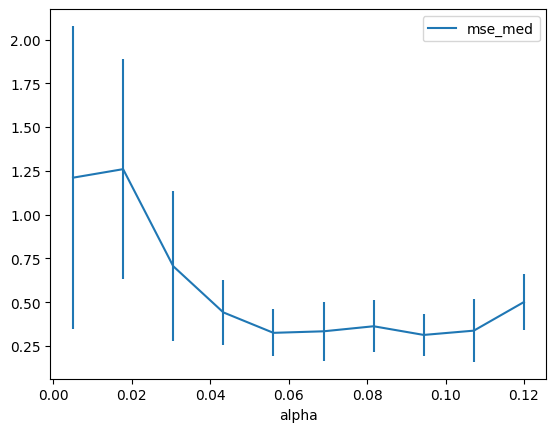

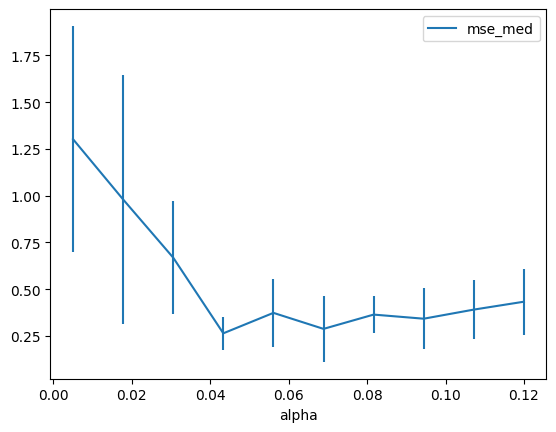

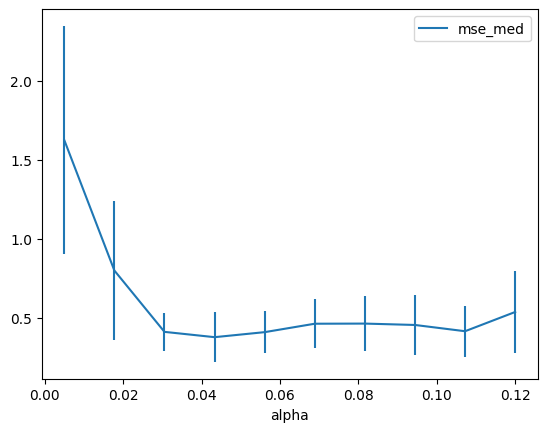

In [111]:
df[(df.j == False) & (df.avg == True)].groupby("offset").plot(x = "alpha", y = "mse_med", yerr = "mse_med_sd")

In [116]:
df.sort_values(by = "ocp_mean", ascending = False).head()

,avg,alpha,j,offset,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
19,True,0.043333,False,0.10,0.841008,0.050507,0.442010,0.442010,0.0,0.004125,0.187431
24,True,0.056111,True,0.10,0.839147,0.047167,0.384100,0.384100,0.0,0.008761,0.215535
18,True,0.043333,True,0.10,0.837771,0.046895,0.350927,0.350927,0.0,0.004356,0.152804
25,True,0.056111,False,0.10,0.835684,0.046185,0.325250,0.325250,0.0,0.004830,0.134371
20,True,0.043333,True,1.05,0.833515,0.047736,0.266856,0.266856,0.0,0.005099,0.119937


This confirms it: We obtain the best performance with **averaging, no jitter, alpha = 0.04, offset = 0.1.**

# Weights on different seed dimensions

In [33]:
alpha_vals= np.linspace(0.005, 0.1, num=5)
results = [ ]

# random.seed(5)
# randoms = [random.randrange(0,100) for _ in range(10)]
randoms = [123]

for randval in randoms:
    for alphaval in alpha_vals:
        method = { "method": "attseed",
                  "feature_dim" : feature_dim,
                  "numfolds" : 5,
                  "alpha" : alphaval}


        evals = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
        ocp_mean, ocp_stdev, mse_mean, mse_stdev, mse_med = ocp_mse_crossvalidation_readoff(evals)

        print(alphaval, oval, jval, ocp_mean, mse_med)

        results.append( {"alpha": alphaval,  
                         "ocp_mean" : ocp_mean, "ocp_stdev" : ocp_stdev, 
                         "mse_mean" : mse_mean, "mse_stdev" : mse_stdev, "mse_med" : mse_med})



0.005 2.0 True 0.5912197656840514 14.175129779027884
0.02875 2.0 True 0.6004782416604418 12.265447819616575
0.0525 2.0 True 0.6162730863241067 18.06967147011501
0.07625000000000001 2.0 True 0.6030656682697498 18.074386214012044
0.1 2.0 True 0.6087721304898176 11.930152491036031


In [35]:
df = pd.DataFrame(results)

In [36]:
df.sort_values(by = "ocp_mean", ascending = False)

,alpha,ocp_mean,ocp_stdev,mse_mean,mse_stdev,mse_med
2,0.05250,0.616273,0.102229,18.069671,0.0,18.069671
4,0.10000,0.608772,0.065102,11.930152,0.0,11.930152
3,0.07625,0.603066,0.090584,18.074386,0.0,18.074386
1,0.02875,0.600478,0.106305,12.265448,0.0,12.265448
0,0.00500,0.591220,0.112384,14.175130,0.0,14.175130


The results are all not great, but we obtain the best results, in terms of OC_P, for **alpha = 0.05**. In terms of MSE they are better for alpha = 0.1. 

# Weights on seed dimensions, adding seed words

In [28]:
alpha_vals= np.linspace(0.005, 0.1, num=5)
jitter_vals = [True, False]
offset_vals= np.linspace(0.1, 2, num=3)
results = [ ]

# random.seed(5)
# randoms = [random.randrange(0,100) for _ in range(10)]
randoms = [123]

for randval in randoms:
    for alphaval in alpha_vals:
        for jval in jitter_vals:
                for oval in offset_vals:
                    method = { "method": "attcombined",
                              "feature_dim" : feature_dim,
                              "numfolds" : 5,
                              "alpha" : alphaval,
                              "offset" : oval,
                              "jitter" : jval,
                             }


                    evals = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
                    ocp_mean, ocp_stdev, mse_mean, mse_stdev, mse_med = ocp_mse_crossvalidation_readoff(evals)

                    print(alphaval, oval, jval, ocp_mean, mse_med)

                    results.append( {"alpha": alphaval, "j": jval, "offset": oval, 
                                     "ocp_mean" : ocp_mean, "ocp_stdev" : ocp_stdev, 
                                     "mse_mean" : mse_mean, "mse_stdev" : mse_stdev, "mse_med" : mse_med})



0.005 0.1 True 0.5856580251518226 16.672478503886325
0.005 1.05 True 0.586671262153637 15.385596656503079
0.005 2.0 True 0.5967504761316832 17.52287105957711
0.005 0.1 False 0.6098924887785432 23.18717104466776
0.005 1.05 False 0.5843061568061568 51.987886265311
0.005 2.0 False 0.5949044752581167 16.011502366473856
0.02875 0.1 True 0.6075401354297458 18.361060229169123
0.02875 1.05 True 0.5949225302286527 9.746587099192654
0.02875 2.0 True 0.5942073948912474 21.132031824060515
0.02875 0.1 False 0.6143694942280286 16.549364411999143
0.02875 1.05 False 0.5799949738470147 6.802420496389969
0.02875 2.0 False 0.5985500104541357 24.939165282717113
0.0525 0.1 True 0.6110744716356962 13.81235807907875
0.0525 1.05 True 0.6146151864009006 15.207989446789874
0.0525 2.0 True 0.6059260045824671 11.176803251175814
0.0525 0.1 False 0.6133383846564119 9.442780088172338
0.0525 1.05 False 0.6033444522220033 21.310733855105877
0.0525 2.0 False 0.5958548679211945 14.543178438438702
0.07625000000000001 0.1

In [117]:
df = pd.DataFrame(results) 

In [30]:
df.sort_values(by = "ocp_mean", ascending = False).head()

,alpha,j,offset,ocp_mean,ocp_stdev,mse_mean,mse_stdev,mse_med
26,0.10000,True,2.00,0.617385,0.079642,9.759925,0.0,9.759925
24,0.10000,True,0.10,0.616861,0.077956,11.112188,0.0,11.112188
20,0.07625,True,2.00,0.614919,0.081265,17.406527,0.0,17.406527
13,0.05250,True,1.05,0.614615,0.097345,15.207989,0.0,15.207989
9,0.02875,False,0.10,0.614369,0.077373,16.549364,0.0,16.549364


The results are all not great but they are best at **alpha = 0.1 with jitter and offest 2.0.**